<div class="alert alert-success">
    <h1>Assignment 1: Linear Regression</h1>
    <h3 align='center'>Machine Learning Course (Fall 2018)</h3>
    <h5 align='center'>Seyed Naser RAZAVI</h5>
</div>

Note that the contents in this assigment and the following assignments are heavily inspired from the amazing machine learning course presented at Stanford by Andrew Ng.

However, here in this series assignments for our machine learning course, we have used **Python** language which we think is much more suitable than Matlab for artificial intelligence students. Also we have changed and modified some parts of the assignments and the related descriptions for those parts.

## Linear Regression

First, let us import two useful python library which we will use through this assinment.
- The first library is `numpy` to work with N-dimensional arrays.
- The second library is `matplotlib` for plotting.

In [153]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# setup for printing numpy arrays
np.set_printoptions(precision=2)

from sklearn.linear_model import LinearRegression

## Part 0: Warm up!

In this part, you will write a very simple function in python which creates and prints a 5-by-5 identity matrix. Complete the definition of the following function, by adding `A = np.eye(5)` to it.

In [2]:
def warm_up():
    ### your code here ###
    A = np.eye(5)
    print(A)


Now that you have defined this function, you can call it by executing the following cell. After running this cell, you should see something like this:
```python
[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]
```

Recall: To run a cell, you can use `<Shift> + <Enter>` or `<Ctrl> + <Enter>`. 

In [3]:
warm_up()

[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]


## Part 1: Linear regression with one variable

In this part, your task is to implement linear regression with one variable to predict profits for a food truck.

Suppose you are the CEO of a restaurant franchise and are considering different cities for opening a new outlet. The chain already has trucks in various cities and you have data for profits and populations from the cities. You would like to use this data to help you select which city to expand to next.

<img src='imgs/restaurant_dataset.png' width='50%'/>

The file `data/ex1data1.txt` contains the dataset for our linear regression problem. The first column is the `population` of a city and the second column is the `profit` of a food truck in that city. A negative value for profit indicates a loss.

### Loading data

The function `load_data()` has already been set up to load this data for you. It recieves the file name which contains the data (in this case `data/ex1data1.txt`) and returns `X` and `y` as 2D matrices.

In [4]:
def load_data(fname):
    data = np.genfromtxt(fname, delimiter=',')
    X = data[:, 0].reshape(-1, 1)  # Get the 1st column and convert it to a 2d matrix
    y = data[:, 1].reshape(-1, 1)  # Get the 2nd column and convert it to a 2d matrix
    return X, y

In [5]:
X, y = load_data(fname='data/ex1data1.txt')

print(X.shape)
print(y.shape)

(97, 1)
(97, 1)


A more general implementation of this function is given here. This implementation works for any number of columns in the text file which are separated by commas (This is useful for the next part of this assignment, when we deal with linear regression with multiple variables). 

Here we assume that the first columns of the text file are the input features and the last column is the target value which we are going to predict. Be sure that you understand how we have separated the columns and stored them in `X` and `y`.

In [16]:
def load_data(fname):
    data = np.genfromtxt(fname, delimiter=',')
    n = data.shape[1] - 1            # number of features
    X = data[:, :-1].reshape(-1, n)  # Get all but the last column and convert to a 2d array
    y = data[:,  -1].reshape(-1, 1)  # Get the last column and convert to a 2d array
    return X, y

In [17]:
X, y = load_data(fname='data/ex1data1.txt')

print(X.shape)
print(y.shape)
# X

(97, 1)
(97, 1)


### Plotting data

Before starting on any task, it is often useful to understand the data by visualizing it. For this dataset, you can use a scatter plot to visualize the data, since it has only two properties to plot (`profit` and `population`). (Many other problems that you will encounter in real life are multi-dimensional and can’t be plotted on a 2-d plot.) 

In [8]:
def plot_data(X, y):
    plt.figure(figsize=(12, 8), dpi=120)
    plt.scatter(X, y, s=20, c='r', marker='x', alpha=0.5)## s is for marker size and is scaler or array of the same length as x and y. 
    plt.xlabel('Population of city in 10,000')
    plt.ylabel('Profit in $10,000s')   
    plt.title('Profit vs. Population')

Now, you can call `plot_data` to create a scatter plot of the data. Run the following cell to see the data.

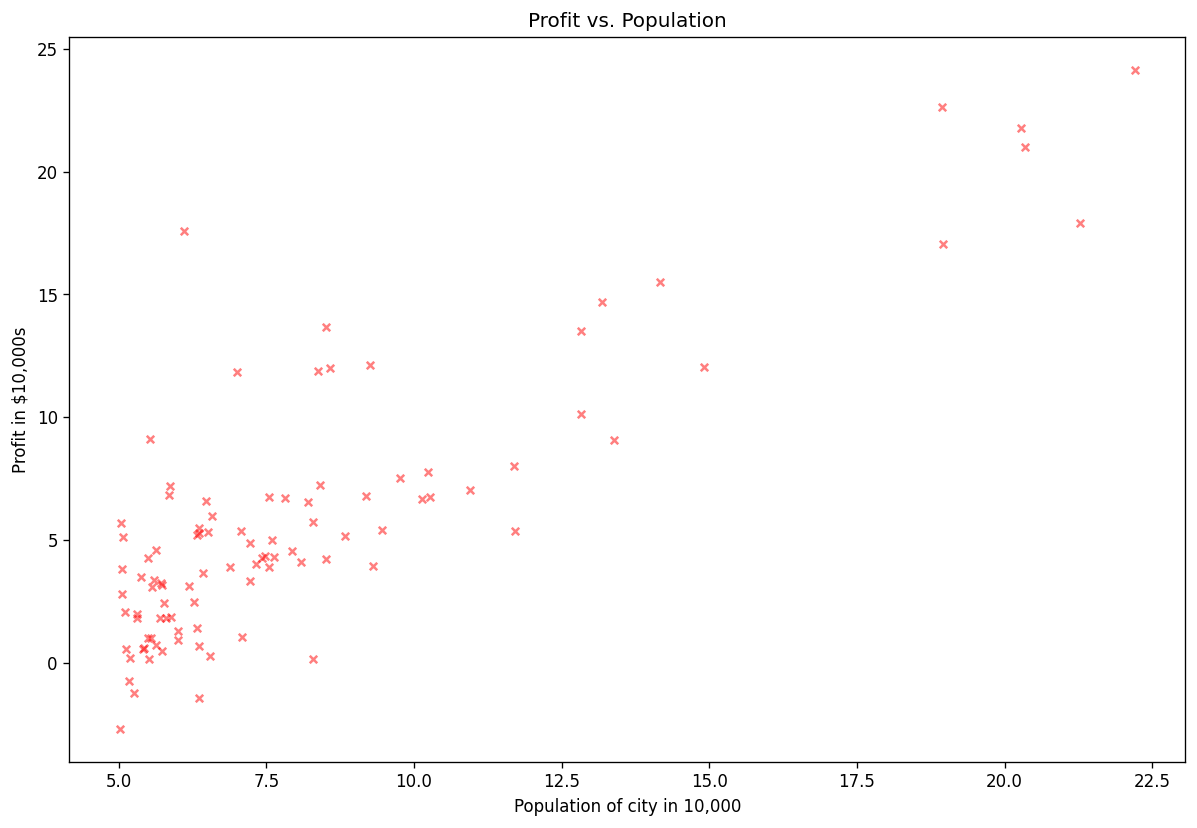

In [9]:
plot_data(X, y)

To learn more about the `scatter` command, you can type `help(plt.scatter)` in a new cell or to search online for plotting documentation. For example, to change the markers to red “x”, we used the options `c='r'` and `marker='x'` together with the scatter command.

In [14]:
help(plt.scatter)

Help on function scatter in module matplotlib.pyplot:

scatter(x, y, s=None, c=None, marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, *, edgecolors=None, plotnonfinite=False, data=None, **kwargs)
    A scatter plot of *y* vs. *x* with varying marker size and/or color.
    
    Parameters
    ----------
    x, y : float or array-like, shape (n, )
        The data positions.
    
    s : float or array-like, shape (n, ), optional
        The marker size in points**2.
        Default is ``rcParams['lines.markersize'] ** 2``.
    
    c : array-like or list of colors or color, optional
        The marker colors. Possible values:
    
        - A scalar or sequence of n numbers to be mapped to colors using
          *cmap* and *norm*.
        - A 2D array in which the rows are RGB or RGBA.
        - A sequence of colors of length n.
        - A single color format string.
    
        Note that *c* should not be a single numeric RGB or RGBA sequence
    

### Gradient descent

In this part, you will ﬁt the linear regression parameters $\theta$ to our dataset using gradient descent.


#### Update Equations

The objective of linear regression is to minimize the **cost function** (here, MSE)
$$J(\theta) = \frac{1}{2m} \sum_{i=1}^{m} (h_\theta(x^{(i)}) - y^{(i)})^2$$
where the **hypothesis** $h_\theta(x)$ is given by the linear model
$$h_\theta(x) = \theta^T x = \theta_0 + \theta_1 x$$


Recall that the parameters of your model are the $\theta_j$ values. These are the values you will adjust to minimize cost $J(\theta)$. One way to do this is to use the **full-batch gradient descent** algorithm. In full-batch gradient descent, each iteration performs the update
$$\theta_j = \theta_j - \alpha \frac{1}{m} \sum_{i=1}^{m} (h_\theta(x^{(i)}) - y^{(i)}) x_{j}^{(i)}$$
With each step of gradient descent, your parameters $\theta_j$ come closer to the optimal values that will achieve the lowest cost $J(\theta)$.


<div class="alert alert-success">
    <strong>Implementation Note:</strong> We store each example as a row in the the $X$ matrix in python. To take into account the intercept term ($\theta_0$), we add an additional first column to $X$ and set it to all ones. This allows us to treat $\theta_0$ as simply another *feature*.
</div>

### Part 1-1: Implementation

#### Hypothesis function

First, let us implement the hypothesis function in linear regression. The following function `h` gets the input data `X` and the parameters as input and outputs predictions by a simple matrix multiplication. Note that the result is a 2d matrix (m-by-1).

 In the following lines, we add another dimension to our data to accommodate the $\theta_0$ intercept term. We also initialize the initial parameters to 0 and the learning rate $\alpha$ to 0.01.

In [10]:
def h(X,theta):
    """
    Hypothesis function for linear regression.
    
    Arguments:
        - X: Input matrix, a 2d array of shape (m, n+1)
        - theta: parameters, a 2d array of shape (n+1, 1)
        
    Output:
        - Predictions for input data (m-by-1)
    """
    return X@theta

Note that in the above code, the first satatement is used to add a column of ones to the left of the input matrix `X`. This is another way to conacatinate matrices in `numpy`. Of course, you could use the `np.concatinate()` or the `np.hstack()` which we saw in the class. Here, I have used `np.c_[]`, because it's a common way for matrix concatination in `numpy` and you will see it a lot in the codes which are available online.

#### Computing the cost function

As you perform gradient descent to learn minimize the cost function J(θ), it is helpful to monitor the convergence by computing the cost. In this section, you will implement a function to calculate J(θ) so you can check the convergence of your gradient descent implementation. 

Your next task is to complete the code in the `compute_cost()` function, which is a function that computes J(θ). As you are doing this, remember that the variables `X` and `y` are not scalar values, but matrices whose rows represent the examples from the training set. 

<div class="alert alert-danger">
    <strong>Imortant Note:</strong> Notice that your implementation must be at most 3 or 4 lines of code and you are not allowed to use loops anywhere in your code. Instead, you should rely on vectorized computations that *numpy* provides for you.
        </ul>
</div>

Note: Because the function is not implemented yet, we have included an exception statement which states "You should implement this function.". To implement the function, you should remove this line and replace it by your code.

In [24]:
m = X.shape[0]
X = np.c_[np.ones((m, 1)), X]  # concatinating a column of 1s
# X_New = np.array([np.ones(len(X)), X.flatten()]).T
# ones = pd.DataFrame(np.ones((m, 1)), columns=['ones'])
# X = pd.concat([ones, X], axis=1)

theta = np.zeros((2, 1))                # initialize parameters to 0
alpha = 0.01                            # learning rate
num_iterations = 1500

print((1/2*m))
print((1/(2*m)))

48.5
0.005154639175257732


In [25]:
X.shape

(97, 2)

In [26]:
def compute_cost(X, y, theta):
    """ Vectorized implementation of MSE cost function.
    
    Arguments:
        - X: Inputs, a 2d array of shape (m, n + 1)
        - y: Target values, a 2d array of shape (m, 1)
        - theta: Parameters, a 2d array of shape (n + 1, 1)
        
    Outputs:
        - the mean squared error value
    """
    theta = np.zeros((2, 1), dtype=float)  

    J = (1/(2*m))*np.transpose((h(X, theta)-y))@(h(X, theta)-y)
    return(J)
    raise NotImplementedError('You should implement compute_cost function')

Once you have completed the function, the next step will run `compute_cost()` once using θ initialized to zeros, and you will see the cost printed to the screen. You should expect to see a cost of `32.07`.

In [27]:
print('J([0, 0]) = %.2f' % compute_cost(X, y, theta))

J([0, 0]) = 32.07


#### Gradient descent

Now, it is time to implement gradient descent algorithm. An unvectorized implementation of full-batch gradient descent algorithm is already written for you. The unvectorized implementation is correct and works fine for the purpose of this assignment. 

But keep in mind that always use a **vectorized implementation** for real world problems, because the vectorized implementation is *much faster* and also *much simpler* comparing to the unvectorized implementation.

In [28]:
def gradient_descent_unvectorized(X, y, theta, alpha, num_iterations):
    """ Unvectorized implementation of full-batch gradient descent.
    
    Arguments:
        - X: Inputs, a 2d array of shape (m, n + 1)
        - y: Target values, a 2d array of shape (m, 1)
        - theta: Initial guess for parameters, a 2d array of shape (n + 1, 1)
        - alpha: Learning rate (or step size) in G.D. algorithm
        - num_iterations: Maximum number of iterations in G.D. algorithm
        
    Outputs:
        - theta: the final value of parameters after learning
    """
    m, n = X.shape
    
    for iteration in range(num_iterations):
        
        # compute cost for current value of paremetrs
        cost = compute_cost(X, y, theta)
        
        # print cost every 100 iterations
        if iteration % 100 == 0:
            print('%4d: J(%s) = %.2f' %(iteration, theta.ravel(), cost))
        
        # compute gradients
        grads = np.zeros_like(theta)
        
        for j in range(n):
            for i in range(m):
                term = h(X[i], theta) - y[i]
                grads[j] += X[i, j] * term
        
        # update parameters
        for j in range(n):
            theta[j] = theta[j] - (alpha / m) * grads[j]  
            
    return theta

Now, let us run the unvectorized implementation of the full-batch gradient descent algorithm to see some results. Run the following cell to see the results.

In [30]:
# load data
X, y = load_data('data/ex1data1.txt')

# add the column of ones to the X
X = np.c_[np.ones((X.shape[0], 1)), X]

# run gradient descent algorithm
theta = np.random.randn(2, 1)
alpha = 0.01
num_iterations = 2001
theta = gradient_descent_unvectorized(X, y, theta, alpha, num_iterations)

   0: J([ 0.1  -1.07]) = 32.07
 100: J([-0.4   0.84]) = 32.07
 200: J([-0.98  0.9 ]) = 32.07
 300: J([-1.46  0.95]) = 32.07
 400: J([-1.86  0.99]) = 32.07
 500: J([-2.2   1.02]) = 32.07
 600: J([-2.48  1.05]) = 32.07
 700: J([-2.71  1.07]) = 32.07
 800: J([-2.91  1.09]) = 32.07
 900: J([-3.07  1.11]) = 32.07
1000: J([-3.21  1.12]) = 32.07
1100: J([-3.32  1.14]) = 32.07
1200: J([-3.42  1.14]) = 32.07
1300: J([-3.49  1.15]) = 32.07
1400: J([-3.56  1.16]) = 32.07
1500: J([-3.62  1.16]) = 32.07
1600: J([-3.66  1.17]) = 32.07
1700: J([-3.7   1.17]) = 32.07
1800: J([-3.73  1.18]) = 32.07
1900: J([-3.76  1.18]) = 32.07
2000: J([-3.78  1.18]) = 32.07


<div class="alert alert-success">
    <strong>Verification of Gradient Descent: </strong>  A good way to verify that gradient descent is working correctly is to look at the value of J(θ) and check that it is decreasing with each step. Assuming you have implemented the compute_cost() function correctly, your value of J(θ) should never increase, and should converge to a steady value by the end of the algorithm.
</div>

#### Gradient descent: vectorized implementation

Now, your task is to implement the vectorized version of the full-batch gradient descent algorithm by inspiring the unvectorized version we provided for you. Complete the following function named `gradient_descent()` to finish the task. Not that a correct implementation must be 5 or 6 lines of code at most.

As you program, make sure you understand what you are trying to optimize and what is being updated. Keep in mind that the cost J(θ) is parameterized by the vector θ, not X and y. That is, we minimize the value of J(θ) by changing the values of the vector θ, not by changing X or y. Refer to the equations in this handout and to the video lectures if you are uncertain. 

In [88]:
def gradient_descent(X, y, theta, alpha, num_iterations):
    """ A vectorized implementation of full-batch gradient descent.
    
    Arguments:
        - X: Inputs, a 2d array of shape (m, n + 1)
        - y: Target values, a 2d array of shape (m, 1)
        - theta: Initial guess for parameters, a 2d array of shape (n + 1, 1)
        - alpha: Learning rate (or step size) in G.D. algorithm
        - num_iterations: Maximum number of iterations in G.D. algorithm
        
    Outputs:
        - theta: the final value of parameters after learning
    """
    theta = np.zeros((2, 1),dtype = float) 
    cost_hist = np.zeros(num_iterations)
    j_history = []
    m = len(X)
    # Computing the cost and theta in iterations
    for i in range(num_iterations):    
        
        Grad = X.T@((X@theta - y))
        theta = theta - (alpha/m)*(Grad)
        cost_hist[i] = compute_cost(X, y, theta)
        j_history.append(compute_cost(X, y, theta)[0])

#     plt.scatter(X[:,1].reshape(-1,1), y, c = "red")
#     plt.plot(X[:,1].reshape(-1,1), X@theta, c ="blue")
#     plt.xlabel("Population of city in 10,000")
#     plt.ylabel("Profit in $10,000s")   
#     plt.title("Profit vs. Population")
#     plt.show()
    
#     plt.plot(np.arange(num_iterations),cost_hist)
    return theta

    raise NotImplementedError('You should implement gradient_descent function.')
gradient_descent(X, y, theta, alpha, num_iterations)

array([[-3.79],
       [ 1.18]])

After you are finished, use your final parameters to plot the linear fit. The result should look something like this:

<img src='imgs/linear_regression_result_for_restaurant_dataset.png' width='70%'>

In [89]:
# ##Predition
# theta = gradient_descent(X, y, theta, alpha, num_iterations)
# np.array([1, 3.5]).dot(theta)

Your ﬁnal values for θ will also be used to make predictions on profits in areas of 35,000 and 70,000 people. Note the way that the following lines uses matrix multiplication, rather than explicit summation or looping, to calculate the predictions. This is an example of **code vectorization** in Python.


In [90]:
def part2_1():
    # load and prepare data
    X, y = load_data('data/ex1data1.txt')
    X = np.c_[np.ones((X.shape[0], 1)), X]
    
    # initialization
    theta = np.zeros((2, 1))
    alpha = 0.01
    num_iterations = 1500
    
    # print cost for initial value of parameters
    cost = compute_cost(X, y, theta)  # should be 32.07
    print("Cost = %.2f" % cost)
    
    # run gradient descent
    new_theta = gradient_descent(X, y, theta, alpha, num_iterations)
    
    # print the final value of parameters after running G.D.
    print("theta = %s" % new_theta.ravel())
    
    # predict for two different inputs
    prediction1 = np.array([1, 3.5]).dot(new_theta)
    prediction2 = np.array([1, 7.0]).dot(new_theta)
    print("Prediction for 3.5 is: %.2f" % prediction1)
    print("Prediction for 7.0 is: %.2f" % prediction2)
    
    # plot data and the fit
    plot_data(X[:, 1], y)
    plt.plot(X[:, 1], X @ new_theta, 'k-')
    plt.show()


Cost = 32.07
theta = [-3.63  1.17]
Prediction for 3.5 is: 0.45
Prediction for 7.0 is: 4.53


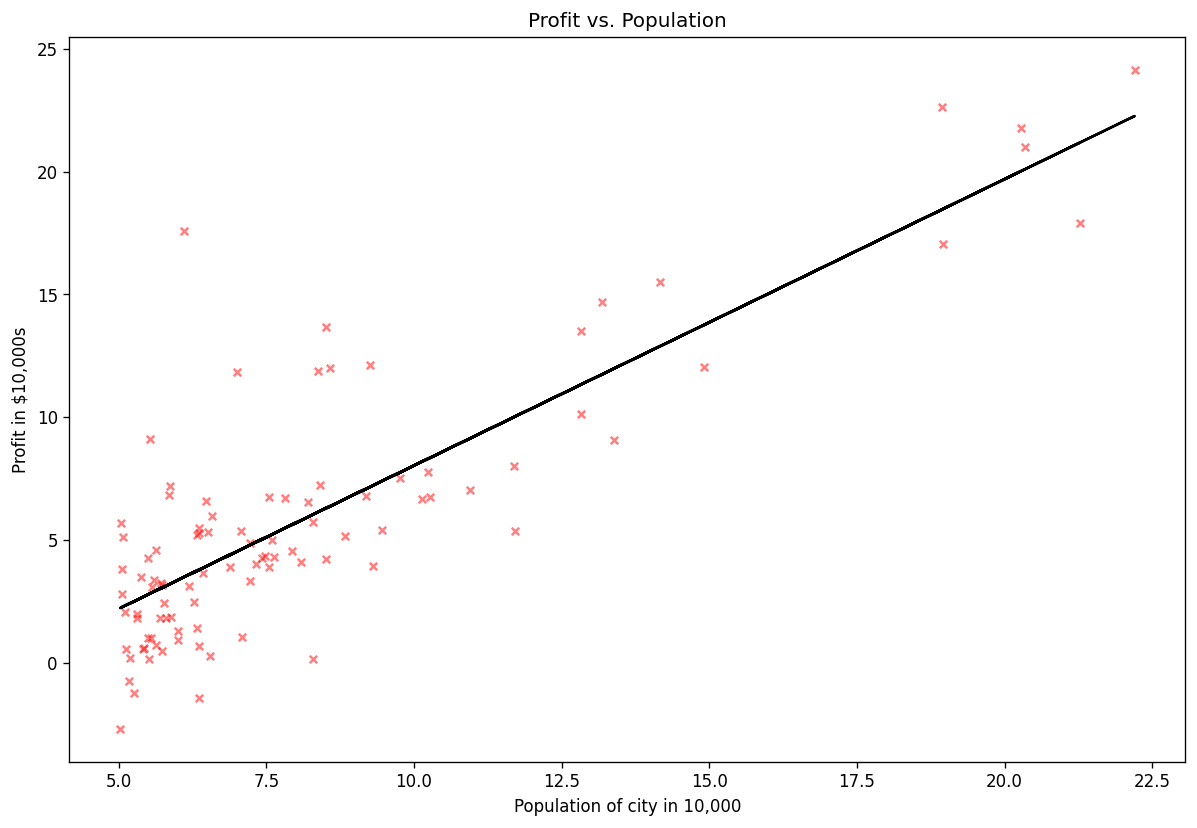

In [91]:
part2_1()

<div class="alert alert-danger">
    <strong>Debugging:</strong> Here are some things to keep in mind as you implement gradient descent:
        <ul>
            <li>Python array indices start from zero, not one. If you’re storing θ0 and θ1 in a vector called theta, the values will be theta[0] and theta[1].</li>
            <li>If you are seeing many errors at runtime, inspect your matrix operations to make sure that you’re adding and multiplying matrices of compatible dimensions. Printing the dimensions of variables with the *shape* command will help you debug.</li>
            <li>By default, Python interprets math operators to be element-wise operators. This is a common source of size incompatibility errors. If you want matrix multiplication, you need to use the `@` operator to specify this to Python. For example, `A * B` does an element-wise matrix multiplication, while `A @ B` does a normal matrix multiplication.</li>
        </ul>
</div>

### Part 1-2: Visualizing $J(\theta)$

To understand the cost function J(θ) better, you will now plot the cost over a 2-dimensional grid of θ0 and θ1 values. You will not need to code anything new for this part, but you should understand how the code you have written already is creating these images. In the next step, there is code set up to calculate J(θ) over a grid of values using the `compute_cost()` function that you wrote.

In [158]:
def part1_2():
    # load and prepare data
    X, y = load_data("data/ex1data1.txt")
    X = np.c_[np.ones((X.shape[0], 1)), X]

    # compute cost function for a range of different values for parameters
    theta0_vals = np.linspace(-20, 20, 100)
    theta1_vals = np.linspace(-6, 6, 100)

    J_vals = np.zeros((len(theta0_vals), len(theta1_vals)), dtype=np.float64)
    for i, v0 in enumerate(theta0_vals):
        for j, v1 in enumerate(theta1_vals):
            theta = np.array((theta0_vals[i], theta1_vals[j])).reshape(2, 1)
            J_vals[i, j] = compute_cost(X, y, theta)

    T0, T1 = np.meshgrid(theta0_vals, theta1_vals)

    # plot cost function
    fig = plt.figure(figsize=(8, 6))
    ax = fig.gca(projection='3d')
    ax.plot_surface(T0, T1, J_vals, cmap=plt.cm.rainbow)
    plt.show()

    # run gradient descent to find optimal theta
    theta = gradient_descent(X, y, theta, alpha=0.02, num_iterations=1500)

    # plot contours of cost function and the final value of parameters
    fig = plt.figure(figsize=(8, 6))
    plt.contour(T0, T1, J_vals.T, np.logspace(-2, 3, 20), cmap=plt.cm.rainbow)
    plt.plot(theta[0], theta[1], 'rx', markersize=10)
    plt.show()

<ipython-input-158-0a5da177cf2b>:20: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


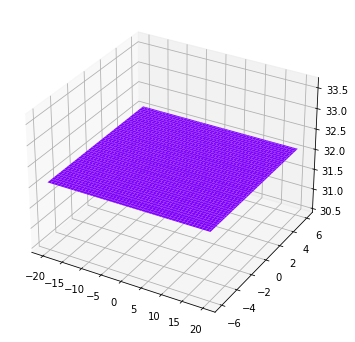

<ipython-input-158-0a5da177cf2b>:29: UserWarning: No contour levels were found within the data range.
  plt.contour(T0, T1, J_vals.T, np.logspace(-2, 3, 20), cmap=plt.cm.rainbow)


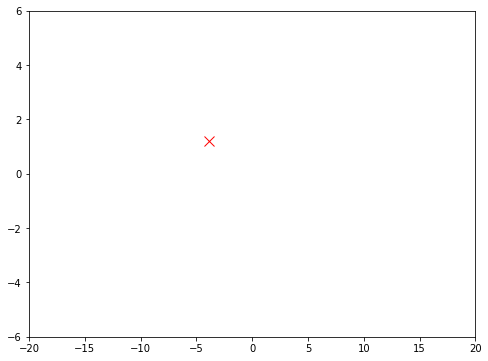

In [159]:
part1_2()

The purpose of these graphs is to show you that how J(θ) varies with changes in θ0 and θ1. The cost function J(θ) is bowl-shaped and has a global mininum. (This is easier to see in the contour plot than in the 3D surface plot). This minimum is the optimal point for θ0 and θ1, and each step of gradient descent moves closer to this point.

# Method: Plotting and Prediction Through Scikit Learn

In [151]:
x_min, x_max = X[:,1].ravel().min(), X[:,1].ravel().max()
xs = [x_min, x_max]

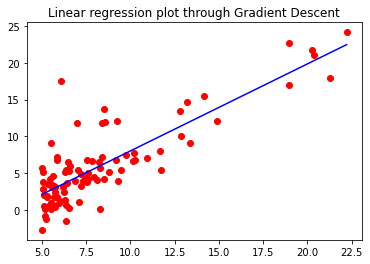

In [152]:
y_Grad = [np.dot([1, x_min], theta)[0], np.dot([1, x_max], theta)[0]]
plt.scatter(X[:,1], y, c="r")
plt.plot(xs, y_Grad, c="b")
plt.title("Linear regression plot through Gradient Descent");

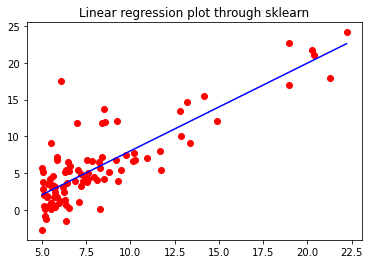

In [137]:
regressor = LinearRegression()
regressor.fit(X,y)
x_min, x_max = X[:,1].ravel().min(), X[:,1].ravel().max()
xs = [x_min, x_max]
# ys = [regressor.predict(x_min)]
ys = [regressor.predict(np.array([[1, x_min]]))[0][0], regressor.predict(np.array([[1, x_max]]))[0][0]]
plt.title("Linear regression plot through sklearn")
plt.scatter(X[:,1], y, c="r")
plt.plot(xs, ys, c="b");

We can see from the above that both plots are the same for both sklearn and Gradient Descents

## Part 2: Multi-variable Linear Regression

In this part, you will implement linear regression with multiple variables to predict the prices of houses. Suppose you are selling your house and you want to know what a good market price would be. One way to do this is to first collect information on recent houses sold and make a model of housing prices.

### Dataset

The file `data/ex1data2.txt` contains a training set of housing prices in Portland, Oregon. The first column is the size of the house (in square feet), the second column is the number of bedrooms, and the third column is the price of the house.

<img src='imgs/house_dataset.png' width='50%'>

### Part 2-1: Feature normalization

By looking at the dataset for this part, note that house sizes are about 1000 times the number of bedrooms. When features differ by orders of magnitude, first performing feature scaling can make gradient descent converge much more quickly.

Your task here is to complete the code in `feature_normalize()` function to:
- Subtract the **mean** value of each feature from the dataset.
- After subtracting the mean, additionally scale (divide) the feature values by their respective **standard deviations**.

In [162]:
def feature_normalize(X):
    """A vectorized implementation of feature normalization.
    
    Arguments:
        - X: The raw input features, a 2d array of shape (m, n)
        
    Outputs:
        - X_norm: The normalized version of the input matrix
        - mu: The mean of the features
        - sigma: The std dev of the features 
    """
    mu = X.mean()
    sigma = X.std()
    X_norm = (X - mu)/(sigma)
    
    return X_norm, mu, sigma

    raise NotImplementedError("You should implement feature_normalize function.")
    
# X_norm, mu, sigma = feature_normalize(X)

The standard deviation is a way of measuring how much variation there is in the range of values of a particular feature (most data points will lie within ±2 standard deviations of the mean); this is an alternative to taking the range of values (max-min). 

In Python, you can use the `std` function from `numpy` to compute the standard deviation and the `mean` function to compute the mean. For example, inside `feature_normalize()`, the quantity `X[:, 0]` contains all the values of x1 (house sizes) in the training set, so `np.std(X[:, 0])` computes the standard deviation of the house sizes. 

**Note:** At the time that `feature_normalize()` is called, the extra column of 1’s corresponding to x0 = 1 has not yet been added to X. 

You will do this for all the features and your code should work with datasets of all sizes (any number of features / examples). Note that each column of the matrix X corresponds to one feature. 

<div class="alert alert-success">
    <strong>Implementation Note:</strong> When normalizing the features, it is important to store the values used for normalization - the *mean* value and the *standard deviation* used for the computations. After learning the parameters from the model, we often want to predict the prices of houses we have not seen before. Given a new x value (living room area and number of bedrooms), we must first normalize x using the mean and standard deviation that we had previously computed from the training set.
</div>

After you finished with writting the `feature_normalize()` function, you can run the following two cells to see the noramalized features (only for first five inputs) and the mean value and the standard deviation for the two input features.

In [186]:
X, y = load_data("data/ex1data2.txt")
X.shape

(47, 2)

In [189]:
def part2_1():
    
    # load data as 2d matrices
    X, y = load_data("data/ex1data2.txt")

    # feature normalization
    X_norm, mu, sigma = feature_normalize(X)
    
    # display the results
    print("Matrix X after normalization:")
    print(X_norm[:5, :])
    
    print("mean = %s " % mu)
    print("std dev = %s" % sigma)
    return X_norm, mu, sigma

In [191]:
X_norm, mu, sigma = part2_1()
part2_1()

Matrix X after normalization:
[[ 0.96 -0.87]
 [ 0.52 -0.87]
 [ 1.22 -0.87]
 [ 0.36 -0.87]
 [ 1.75 -0.87]]
mean = 1001.9255319148937 
std dev = 1143.0528202028345
Matrix X after normalization:
[[ 0.96 -0.87]
 [ 0.52 -0.87]
 [ 1.22 -0.87]
 [ 0.36 -0.87]
 [ 1.75 -0.87]]
mean = 1001.9255319148937 
std dev = 1143.0528202028345


(array([[ 9.64e-01, -8.74e-01],
        [ 5.23e-01, -8.74e-01],
        [ 1.22e+00, -8.74e-01],
        [ 3.62e-01, -8.75e-01],
        [ 1.75e+00, -8.73e-01],
        [ 8.60e-01, -8.73e-01],
        [ 4.65e-01, -8.74e-01],
        [ 3.72e-01, -8.74e-01],
        [ 3.31e-01, -8.74e-01],
        [ 4.30e-01, -8.74e-01],
        [ 8.21e-01, -8.73e-01],
        [ 8.73e-01, -8.74e-01],
        [ 7.77e-01, -8.74e-01],
        [ 3.04e+00, -8.72e-01],
        [ 2.33e-01, -8.74e-01],
        [ 1.14e+00, -8.73e-01],
        [ 2.78e-01, -8.75e-01],
        [ 2.05e-01, -8.74e-01],
        [ 1.41e+00, -8.73e-01],
        [ 1.78e+00, -8.73e-01],
        [ 6.69e-01, -8.74e-01],
        [ 7.75e-01, -8.75e-01],
        [ 5.27e-01, -8.74e-01],
        [ 8.40e-01, -8.73e-01],
        [ 2.53e+00, -8.74e-01],
        [ 8.58e-02, -8.74e-01],
        [ 3.99e-01, -8.74e-01],
        [ 1.33e+00, -8.74e-01],
        [ 1.05e+00, -8.74e-01],
        [ 1.43e+00, -8.74e-01],
        [ 7.32e-01, -8.75e-01],
        

### Part 2-2: Gradient Descent

Previously, you implemented gradient descent on a univariate regression problem. The only diﬀerence now is that there is one more feature in the matrix X. The hypothesis function and the batch gradient descent update rule remain unchanged. 

You should complete the code in `compute_cost_multi()` and `gradient_descent_multi()` to implement the cost function and gradient descent for linear regression with multiple variables. If your code in the previous part (single variable) already supports multiple variables, you can use it here too. 

Make sure your code supports any number of features and is well-vectorized. You can use `X.shape[1]` to ﬁnd out how many features are present in the dataset.


In [192]:
m, n = X.shape[0], X.shape[1]

X = np.c_[np.ones((m, 1)), X_norm]


print(X.shape, y.shape)

theta = np.zeros((3,1))
num_iterations = 400
alpha = 0.01

(47, 3) (47, 1)


In [194]:
def compute_cost_multi(X, y, theta):
    """ A vectorized implementation of MSE cost function
    
    Arguments:
        - X: Inputs, a 2d array of shape (m, n + 1)
        - y: Target values, a 2d array of shape (m, 1)
        - theta: Parameters, a 2d array of shape (n + 1, 1)
        
    Outputs:
        - the mean squared error value
    """
   
    return 1/(2*m)*(np.transpose(X@theta-y)@(X@theta-y))
   
    raise NotImplementedError('You should implement compute_cost_multi function.')
compute_cost_multi(X, y, theta)

array([[6.56e+10]])

In [196]:
# def computeCost(X, y, theta):
#     m = y.shape[0]
#     h_theta = np.matmul(X, theta)
#     error = h_theta - y
#     error_square = np.matmul(error.T, error)
#     J = error_square / (2*m)
    
#     return J

# computeCost(X, y, theta)

# Very important for numpy array, list and dict

In [50]:
# cc = np.zeros(7)
# # print(cc)
# cc[1] = 7
# cc[2] = 8
# print(cc)
# lst = ["jj", "hh"]
# lst[0]="ZAhra"
# print(lst)
# mm ={"gh":56, "ki": 65}
# mm["ki"] = 72
# theta

In [198]:
# def gradientDescent(X, y, theta, alpha, num_iters):
    
#     # Initialize some useful values
#     m = y.shape[0] # number of training examples
#     J_history = np.zeros((num_iters, 1))
#     cost_history = []
# #     y = y.reshape(-1,1)
    
#     for i in range(num_iters):
# #         print(theta)
#         h_theta = np.dot(X, theta)
# #         print(h_theta)
#         error = h_theta - y.reshape(-1,1)
# #         print(error)
#         Grad = alpha * np.dot(X.T, error) / m
# #         print(Grad)
#         theta = theta - Grad
# #         print(theta)
# #         print(computeCost(X, y, theta))##list inside the list# that is why we put the zero iside it
#         cost_history.append(computeCost(X, y, theta)[0])
#         J_history[i] = computeCost(X, y, theta)
# #         print(cost_history)

#     return (theta, J_history, cost_history)
# theta, cost_history, J_history = gradientDescent(X, y, theta, alpha, num_iterations)
# theta
# gradientDescent(X, y, theta, alpha, num_iterations)

array([[ 117739.05],
       [ 152298.64],
       [-102872.88]])

In [200]:
# plt.plot(cost_history);
# plt.plot(np.arange(400), cost_history, 'r')

In [213]:

def gradient_descent_multi(X, y, theta, alpha, num_iterations):
    """ A vectorized implementation of full-batch gradient descent.
    
    Arguments:
        - X: Inputs, a 2d array of shape (m, n + 1)
        - y: Target values, a 2d array of shape (m, 1)
        - theta: Initial guess for parameters, a 2d array of shape (n + 1, 1)
        - alpha: Learning rate (or step size) in G.D. algorithm
        - num_iterations: Maximum number of iterations in G.D. algorithm
        
    Outputs:
        - J_history: a list of computed costs during G.D. algorithm
        - theta: the final value of parameters after learning
    """
    m = y.shape[0]
    J_history = []
#     Grad = (X.T)@(X@theta-y)
    theta_lst = []
    cost_history = np.zeros((num_iterations,1))

    
    for i in range(num_iterations):
        Grad = (1/m) * ((X.T)@(X@theta-y.reshape(-1,1)))
        theta = theta - (alpha)*(Grad)
#         print(theta)
#         predictions = X.dot(theta)
#         error = np.dot(X.transpose(),(predictions -y))
#         descent=alpha * 1/m * error
#         theta-=descent
        J_history.append(compute_cost_multi(X, y, theta)[0])
        cost_history[i] = compute_cost_multi(X, y, theta)
    
    return J_history, theta
    
    raise NotImplementedError('You should implement gradient_descent_multi function.')


theta = [ 119999.48  148539.39 -104839.48]


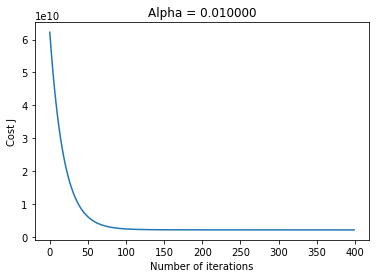

In [214]:
def part2_2():
    
    # load data
    X, y = load_data('data/ex1data2.txt')
    
    # normalize features
    X, mu, sigma = feature_normalize(X)
    
    # add a column of ones to X
    X = np.c_[np.ones((X.shape[0], 1)), X]
    
    # run gradient descent algorithm
    num_iterations = 400
    alpha = 0.01
    theta = np.random.randn(3, 1)
    J_history, theta = gradient_descent_multi(X, y, theta, alpha, num_iterations)
    
    # print the final value of parameters
    print('theta = %s' % theta.ravel())
    
    # plot cost versus iteration
    plt.plot(J_history)
    plt.title("Alpha = %f" % (alpha))
    plt.xlabel('Number of iterations')
    plt.ylabel('Cost J')
    plt.show()
part2_2()


<div class="alert alert-success">
    <strong>Implementation Note:</strong>  In the multivariate case, the cost function can also be written in the following vectorized form:
    $$J(\theta)=\frac{1}{2m}(X \theta - y)^T (X \theta - y)$$
    
    The vectorized version is efficient when you’re working with numerical computing tools like NumPy. If you are an expert with matrix operations, you can prove to yourself that the two forms are equivalent.

</div>

Run the following two cells to see the result of your implementation.

In [231]:
# J_history

In [72]:
# j_val = []
# teta_lst=[]
# for t in newtheta:
#     a = 0.5*np.sum(((t*X) - y)**2)
#     j_val.append(a)
#     teta_lst.append(t)

# print(len(j_val))
# # len(teta_lst)
# plt.plot(j_val, teta_lst );

### Part 2-3: Selecting learning rate

In this part of the exercise, you will get to try out diﬀerent learning rates for the dataset and find a learning rate that converges quickly. You can change the learning rate by modifying and changing the part of the code that sets the learning rate. 

The next phase will call your `gradient_descent()` function and run gradient descent for about 50 iterations at the chosen learning rate. The function should also return the history of J(θ) values in a vector J. After the last iteration, the script plots the J values against the number of the iterations. 

If you picked a learning rate within a good range, your plot look similar Figure 4. If your graph looks very different, especially if your value of J(θ) increases or even blows up, adjust your learning rate and try again. We recommend trying values of the learning rate α on a log-scale, at multiplicative steps of about 3 times the previous value (i.e., 0.3, 0.1, 0.03, 0.01 and so on). You may also want to adjust the number of iterations you are running if that will help you see the overall trend in the curve. To finish this task, just assign a list of candidate learning rates to the variable `alphas` in the following code. You do not need to change any other part of the code.


Notice the changes in the convergence curves as the learning rate changes. With a small learning rate, you should find that gradient descent takes a very long time to converge to the optimal value. Conversely, with a large learning rate, gradient descent might not converge or might even diverge! Using the best learning rate that you found, run gradient descent until convergence to find the final values of θ.

Next, use this value of θ to predict the price of a house with 1650 square feet and 3 bedrooms. You will use value later to check your implementation of the normal equations. Don’t forget to normalize your features when you make this prediction!

In [224]:
def part2_3():
    
    ### load and prepare data
    X, y = load_data("data/ex1data2.txt")
    
    # normalize features
    X, mu, sigma = feature_normalize(X)

    # add a column of ones to X
    X = np.c_[np.ones((X.shape[0], 1)), X]
    
    ### run gradient descent algorithm for a list of different learning rates
    num_iterations = 400
    
    alphas = [] ### your code here ###

    # for each alpha, try to do gradient descent and plot the convergence curve
    for alpha in alphas:
        theta = np.zeros((3, 1))
        J_history, theta = gradient_descent_multi(X, y, theta, alpha, num_iterations)

        # plot cost versus iteration
        plt.plot(J_history)
        plt.title("Alpha = %f" % (alpha))
        plt.xlabel('Number of iterations')
        plt.ylabel('Cost J')
        plt.xlim([0, 50])
        plt.show()
        
part2_3()

In [251]:
from matplotlib.pyplot import cm

In [269]:
def part2_3():
    
    ### load and prepare data
    X, y = load_data("data/ex1data2.txt")
    
    # normalize features
    X, mu, sigma = feature_normalize(X)

    # add a column of ones to X
    X = np.c_[np.ones((X.shape[0], 1)), X]
    
    ### run gradient descent algorithm for a list of different learning rates
    num_iterations = 400
    
#     alphas = [] ### your code here ###
    alphas = [0.3, 0.1, 0.03, 0.01, 0.003, 0.001]
    # for each alpha, try to do gradient descent and plot the convergence curve
    colours = "rgbcym"
#     colors = cm.rainbow(np.linspace(0,1,len(alphas)))
    for alpha, c in zip(alphas, colors):
        theta = np.zeros((3, 1))
        J_history, theta = gradient_descent_multi(X, y, theta, alpha, num_iterations)

        # plot cost versus iteration
        plt.plot(J_history, label = alpha, color = c)
        plt.title("Alpha = %f" % (alpha))
        plt.xlabel('Number of iterations')
        plt.ylabel('Cost J')
        plt.xlim([0, 50])
        plt.legend(bbox_to_anchor=(1.05, 1.0))
        plt.show()

        ## predict price for a 1650 sq feet 3 bedroom house
        x_test = np.array([1.0, 1650.0, 3.0])
        # exclude intercept units when normalizing
        x_test[1:] = (x_test[1:] - mu) / sigma
        prediction = x_test @ theta
        print('Predicted price = %.2f' % prediction[0])


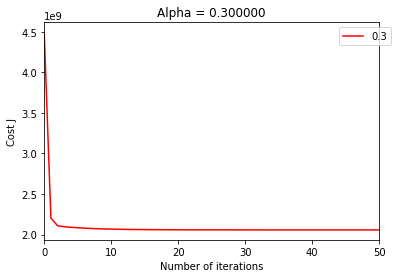

Predicted price = 293237.91


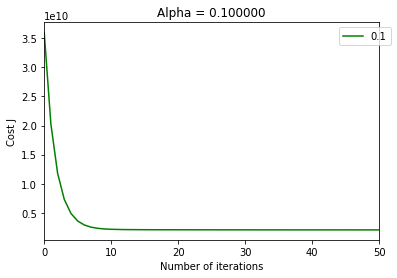

Predicted price = 293237.94


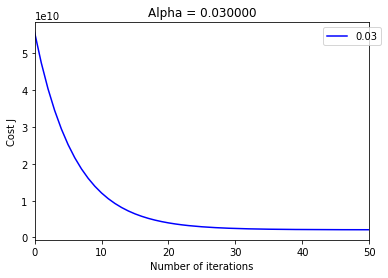

Predicted price = 293452.11


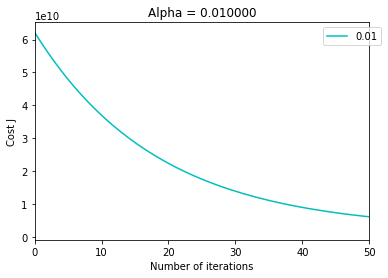

Predicted price = 295836.72


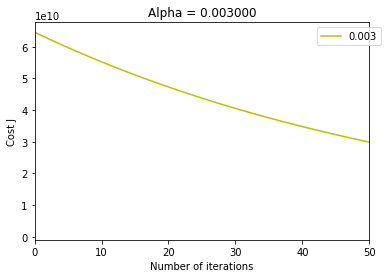

Predicted price = 287628.77


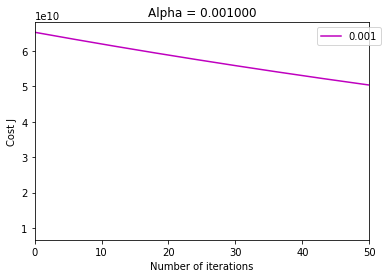

Predicted price = 198288.87


In [272]:
part2_3()

In [276]:

J_history_1, theta_1 = gradient_descent_multi(X, y, theta, 0.3, 400)
J_history_2 ,theta_2 = gradient_descent_multi(X, y, theta, 0.1, 400)
J_history_3,theta_3 = gradient_descent_multi(X, y, theta, 0.03, 400)
J_history_4,theta_4 = gradient_descent_multi(X, y, theta, 0.01, 400)
J_history_5,theta_5 = gradient_descent_multi(X, y, theta, 0.003, 400)
J_history_6,theta_6 = gradient_descent_multi(X, y, theta, 0.001, 400)

Text(0.5, 1.0, 'Different learning rates')

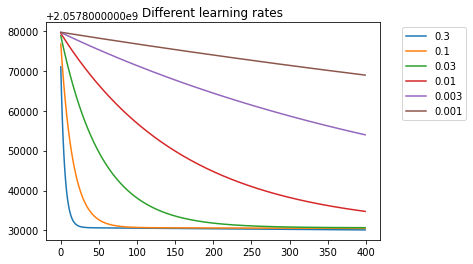

In [277]:
plt.plot(J_history_1, label= "0.3")
plt.plot(J_history_2, label="0.1")
plt.plot(J_history_3, label="0.03")
plt.plot(J_history_4, label="0.01")
plt.plot(J_history_5, label="0.003")
plt.plot(J_history_6, label="0.001")
plt.legend(bbox_to_anchor=(1.05, 1.0))
plt.title("Different learning rates")

## Part 3: Normal Equation

In the lecture videos, you learned that the closed-form solution to linear regression is
$$\theta = (X^T X)^{-1} X^T y$$

Using this formula does not require any feature scaling, and you will get an exact solution in one calculation: there is no “loop until convergence” like in gradient descent. 

Complete the code in `normal_equation()` to use the formula above to calculate θ. Remember that while you don’t need to scale your features, we still need to add a column of 1’s to the X matrix to have an intercept term (θ0).


In [225]:
from numpy.linalg import pinv

In [228]:
def normal_equation(X, y):
    theta = np.linalg.pinv(X.T@X)@(X.T)@y
    return theta
    raise NotImplementedError('You should implement normal_equation function.')
normal_equation(X, y)

array([[-8525767.83],
       [  159125.15],
       [-9988017.41]])

Now, once you have found θ using this method, use it to make a price prediction for a 1650-square-foot house with 3 bedrooms. You should ﬁnd that gives the same predicted price as the value you obtained using the model fit with gradient descent.

In [229]:
def part3():
    
    # load and prepare data
    X, y = load_data("data/ex1data2.txt")
    X = np.c_[np.ones((X.shape[0], 1)), X] # add intercept to X

    # find theta using normal equation
    theta = normal_equation(X, y)
    
    # predict price for a 1650 sq feet 3 bedroom house
    x_test = np.array([1.0, 1650.0, 3.0])
    prediction = x_test @ theta
    print('Predicted price = %.2f' % prediction[0])

In [230]:
part3()

Predicted price = 293081.46


## Submittion

After finishing the assignment, please send **only** this jupyter notebook file via Piazza as a **private** post before the due date. Before submitting your file, be sure to read the following terms and conditions.

**Due date**: November, 2, 2018.

### Terms and Conditions
Please consider the following terms and conditions and take them as serious as you can:
- If you send your code as a public code in Piazza, you will fail in the course.
- If you share all or some parts of your results on the internet or with your friends and classmates in any form, you will fail the course.
- If you submit codes that is not your work, (for example by copying your friend's codes), you will fail the course.
- Any other attempt to cheat, will result in a failure in the course.
- By submmiting this file to Piazza, you confirm that you have read and accepted the above terms and conditions.